In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [43]:
df = pd.read_csv('spotify_data_cleaned.zip')

In [44]:
def clean_outliers(df_aux, columns: list)->pd.DataFrame:
    for column in columns:
        Q1 = df_aux[column].quantile(0.25)
        Q3 = df_aux[column].quantile(0.75)
        IQR = Q3 - Q1
        df_aux = df_aux[(df_aux[column] >= Q1-1.5*IQR) & (df_aux[column] <= Q3 + 1.5*IQR)]
    return df_aux

In [ ]:
#Graficas distribucion
features = [
('popularity', 'Popularity'),
('energy', 'Energy'),
('danceability', 'Danceability'),
('loudness', 'Loudness'),
('speechiness', 'Speechiness'),
('acousticness', 'Acousticness'),
('instrumentalness', 'Instrumentalness'),
('liveness', 'Liveness'),
('valence', 'Valence'),
('tempo', 'Tempo')
]

fig, ax = plt.subplots(5, 2, figsize=(10, 6))

for i, (feature, title) in enumerate(features):
    row, col = divmod(i, 2)
    ax[row, col].hist(df[feature], bins=20, color="skyblue", edgecolor='black', linewidth=0.8)
    ax[row, col].title.set_text(title)

fig.tight_layout()

plt.savefig('imagenes/distribucion.png', dpi=275)

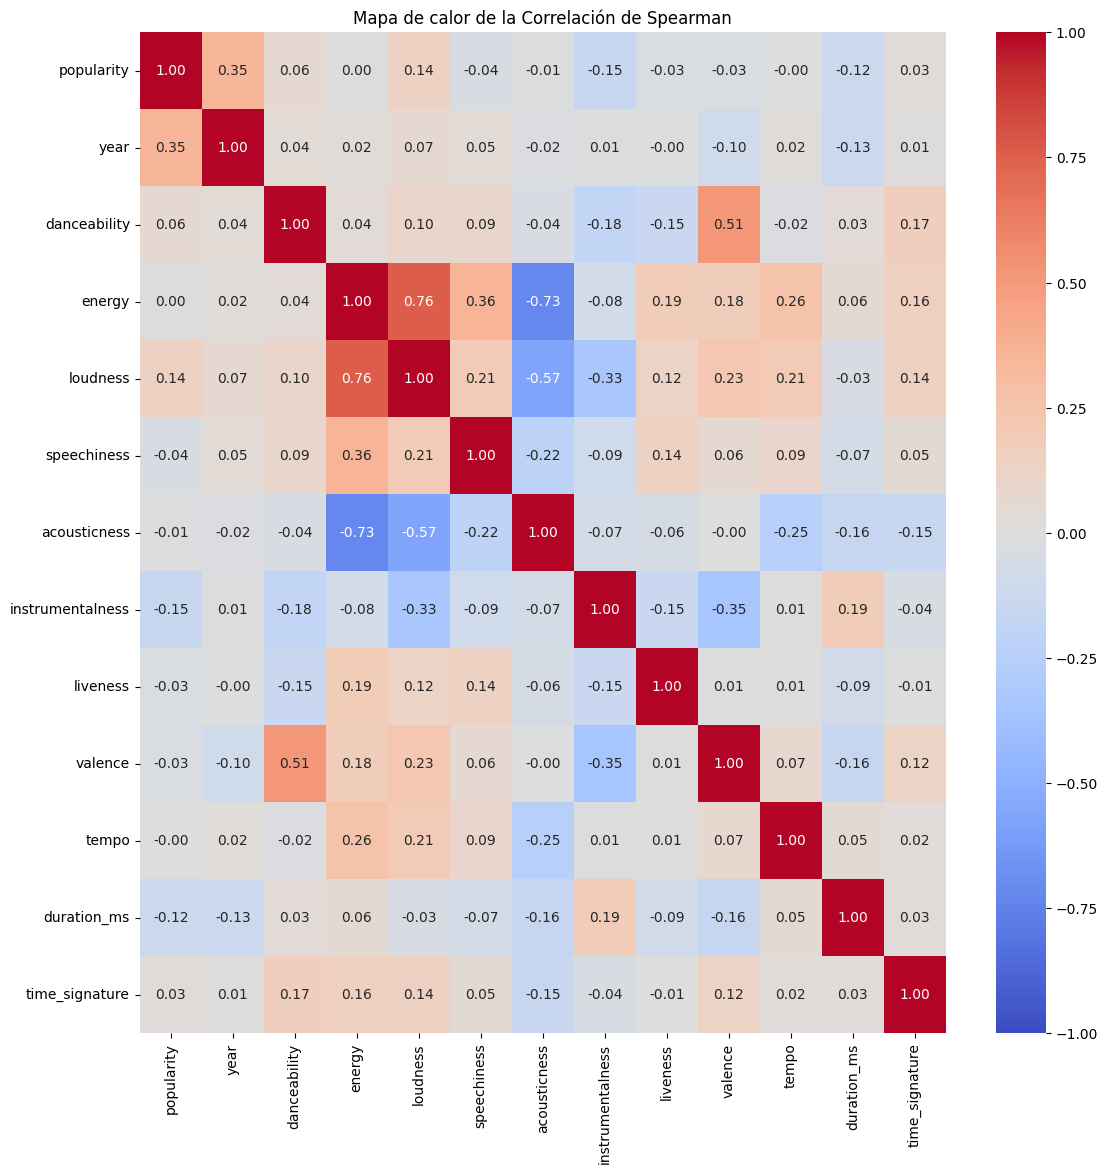

In [72]:
corr_matrix = df.corr(method='spearman', numeric_only=True)

plt.figure(figsize=(13, 13))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Mapa de calor de la Correlación de Spearman')
plt.savefig('imagenes/spearman.png', dpi=200)

In [ ]:
songs_per_artist = df.groupby('artist_name', as_index=False)['track_name'].count()

songs_per_artist.rename(columns={'track_name': 'song_count'}, inplace=True)

top_50_artists = songs_per_artist.sort_values(by='song_count', ascending=False).head(50)

fig = px.treemap(top_50_artists, 
                path=['artist_name'], 
                values='song_count',
                color='song_count', 
                color_continuous_scale='RdYlGn',
                title='Top 50 Artistas con Más Canciones')

fig.update_traces(hovertemplate='Artista: %{label}<br>Número de Canciones: %{value}')

fig.show()

In [ ]:
df['genre'] = df['genre'].apply(lambda x: x.capitalize())

artist_info = df.groupby('artist_name').agg({
    'popularity': 'mean',
    'genre': 'first'  # Concatena géneros únicos
}).reset_index()

artist_info.rename(columns={'popularity': 'average_popularity'}, inplace=True)

top_50_artists = artist_info.sort_values(by='average_popularity', ascending=False).head(50)

fig = px.treemap(top_50_artists, 
                path=['artist_name'], 
                values='average_popularity',
                color='average_popularity', 
                color_continuous_scale='RdYlGn',
                title='Top 50 Artistas con la media más alta de popularidad',
                custom_data=['genre'],
                hover_data={
                    'genre': True,  # Incluye 'genre' en el hover sin cambiar el nombre
                    'average_popularity': ':.2f'  # Formatea 'average_popularity'
                })

fig.update_traces(hovertemplate='Artista: %{label}<br>Popularidad Media: %{value:.2f}<br>Género(s): %{customdata[0]}')

fig.show()

In [ ]:
df_aux = df
df_aux['loudness_color'] = df_aux['loudness'].apply(lambda x: 'Menor que cero' if x < 0 else 'Mayor o igual a cero')

color_map = {'Menor que cero': '#add8e6', 'Mayor o igual a cero': '#2874A6 '}
fig = px.histogram(df_aux, x='loudness', y="energy", histfunc='avg', 
                title='Histograma del Volumen con la Energía Promedio',
                color='loudness_color',
                labels={'loudness': 'Volumen', 'energy': 'Energía'},
                color_discrete_map=color_map,
                nbins=30) 

box = go.Figure(go.Box(x=df['loudness'], boxmean=True, name="Boxplot", marker_color="#cccccc"))

for trace in box.data:
    fig.add_trace(go.Box(x=trace['x'], boxmean=True, marker_color="#148F77"))

fig.update_layout(xaxis_title='Loudness', yaxis_title='Energy', showlegend=False)
fig.show()
fig.write_html('html/volumenenergia.html')


In [ ]:
fig = px.histogram(y=df['popularity'], x=df['genre'], histfunc="avg"
            , animation_frame=df["year"], title="Popularidad de los Géneros a lo largo de los años"
            , labels={"y": "Popularidad", "x": "Género", "animation_frame": "Año" }
            , category_orders={"animation_frame": df["year"].sort_values(ascending=True)}
            )
fig.update_layout(xaxis_tickfont_size=11)
fig.update_xaxes(categoryorder="total ascending", tickangle=-35, title_standoff=0)
fig.update_layout(yaxis_title='Media de Popularidad')
fig.show()
fig.write_html('html/popularidadgeneros.html')


In [51]:
top=30
df_aux = df.sort_values(by='popularity', ascending=False).head(top)

In [ ]:
fig = px.area(df_aux, x='track_name', y='danceability', title=f'Top {top} canciones con mayor popularidad y su danceability'
        , hover_data=["artist_name", "popularity"], labels={"danceability": "Danceability", "track_name": "Canción", "artist_name": "Artista", "popularity": "Popularidad"}
        , markers=True)
fig.show()

In [ ]:
df_aux = clean_outliers(df, ['tempo'])
fig = px.histogram(df_aux, x='tempo', y='danceability', title=f'Bailabilidad en base al tempo de las canciones'
        , hover_data=["artist_name", "popularity"]
        , labels={"danceability": "Danceability", "track_name": "Canción", "artist_name": "Artista", "popularity": "Popularidad"}
        , histfunc="avg")
fig.update_layout(xaxis_title='Tempo', yaxis_title='Media Bailabilidad')
fig.show()
fig.write_html('html/tempobailable.html')

In [ ]:
ax = sns.histplot(df, x="tempo", y="danceability", bins=30
                , cbar=True
                , cbar_kws=dict(shrink=.75))
ax.add_line(plt.axvline(df['tempo'].mean(), color='red', linestyle='--', label='Media', alpha=0.2))
ax.xaxis.set_label_text("Tempo")
ax.yaxis.set_label_text("Danceability")
ax.set_title("Distribución de Tempo y Bailabilidad")

ax.figure.savefig('imagenes/tempobailable.png', dpi=200)

In [ ]:
fig = px.histogram(df, x='popularity', y="energy", title='Media de la energía en base a la popularidad según el año'
        , labels={"year": "Año"}
        , animation_frame="year"
        , category_orders={"year": df["year"].sort_values(ascending=True)}
        , range_y=[0, 1]
        , range_x=[0, 100]
        , histfunc="avg")
fig.update_layout(xaxis_title='Popularidad', yaxis_title='Media de Energía')
fig.show()
fig.write_html('html/energiapopularidad.html')

In [ ]:
fig = px.histogram(df, x='popularity', y="valence", title='Media de la positividad en base a la popularidad según el año'
        , labels={"year": "Año"}
        , animation_frame="year"
        , category_orders={"year": df["year"].sort_values(ascending=True)}
        , range_y=[0, 1]
        , range_x=[0, 100]
        , histfunc="avg")
fig.update_layout(xaxis_title='Popularidad', yaxis_title='Media de Positividad')
fig.show()
fig.write_html('html/positividadpopularidad.html')

In [ ]:
fig = px.histogram(df, x='mode', y="popularity", title='Media de la popularidad en base al modo'
            , histfunc="avg")
fig.update_layout(xaxis_title='Modo', yaxis_title='Media de Popularidad')
fig.update_traces(hovertemplate='Modo: %{x}<br>Media de Popularidad: %{y:.2f}')
fig.show()
fig.write_html('html/modopopularidad.html')

In [ ]:
fig = px.histogram(df, x='key', y="popularity", title='Media de la popularidad en base a la escala de la canción'
            , labels={"key": "Escala"}
            , color="key"
            , histfunc="avg"
            , category_orders={"key": ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]})
fig.update_layout(xaxis_title='Escala', yaxis_title='Media de Popularidad')
fig.update_traces(hovertemplate='Escala: %{x}<br>Media de Popularidad: %{y:.2f}')
fig.show()
fig.write_html('html/escalapopularidad.html')

In [59]:
df_aux = df.sort_values(by='popularity', ascending=False).head(top)
fig = px.parallel_categories(df_aux, dimensions=['genre', 'key', 'mode', 'popularity'], color="popularity", color_continuous_scale=px.colors.sequential.Agsunset
                            , title=f'Top {top} canciones y su camino hacia la popularidad')